## Project: Wine Recommendation System
#### Author: Pedro Castillejo Garcia
#### Created on: June 2023


#### Description: This is a recommendation system which helps buyers to find wine bottles from a data set to save their time and money. The python algorithms build co-occurrence matrix and based on different parameters such as wine description, country and province of origin, variety, reviews (in a scale from 0-100 points) and price segment, the most similar products are returned from the database as recommendation.

### Loading basic packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
pd.set_option("display.max.columns", None)

### Load the data set winemag-data-130k-v2.csv

In [2]:
data = pd.read_csv('winemag-data-130k-v2.csv', low_memory=False)
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


#### We have some "nan" string values, those are cells that are empty in our table, let's remove them and copy the columns which will be needed to build the engine

In [3]:
wine = data[['title', 'country', 'description', 'points', 'price', 'province', 'variety', 'winery']]
wine = wine.query("title != 'NaN' and country != 'NaN' and description != 'NaN' and points != 'NaN' and price != 'NaN' and province != 'NaN' and variety != 'NaN' and winery != 'NaN'")
wine = wine.dropna()

### Now sort the wines according to their points (with most points on top)

In [4]:
wine = wine.sort_values('points', ascending=False)
wine.head()
wine.shape

(120915, 8)

#### We have 120915 observations in 8 columns which is too much to calculate cosine similarity on any normal computer so let's use only part of the original database. 

In [5]:
wine['points'].describe()
quantile = wine["points"].quantile(0.90)
wine = wine.copy().loc[wine["points"] >= quantile]
wine.shape

(20460, 8)

#### Now a 10% of the original database is remainining (As we are using a quantile of 0.9. That means that the rest up to 1 is what we will be using, that is 0.1, then a 10%, which in this case is around 20500 wines. This amount of data should be enough to prepare reliable recommendation engine. However, if you have more powerful computer, feel free to change the used quantile.

### Let's build the first engine which will be based on description of the wines bottles so we put that column the first one in the table

In [6]:
wine["description"].head()

111756    A hugely powerful wine, full of dark, brooding...
42197     This is the latest release of what has long be...
89729     This new release from a great vintage for Char...
113929    In 2005 Charles Smith introduced three high-en...
7335      Thick as molasses and dark as caramelized brow...
Name: description, dtype: object

### Import class from scikitlearn

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

#### To increase accuracy, we remove all english stop words such as "the", "a" or "is"

In [8]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(wine['description'])

### Import class from scikitlearn

In [9]:
from sklearn.metrics.pairwise import linear_kernel

#### The code from below will create the cosine similarity matrix which be needed to build the engine.

#### If you get memory error, increase the quantile value used to divide dataframe.

In [10]:
cosine_simil = linear_kernel(tfidf_matrix, tfidf_matrix)

In [11]:
indices = pd.Series(wine.index, index=wine['title']).drop_duplicates()

In [12]:
def wine_recommendations(title, cosine_simil=cosine_simil):
    
    # Fit index of the wine to each wine title
    index = indices[title]
    
    # Calculate the similarity score between wine which you selected and the others wines in database
    simil_scores = list(enumerate(cosine_simil[index]))
    
    # Sort the results by the similarity scores
    simil_scores = sorted(simil_scores, key=lambda x: x[1], reverse=True)
    
    # Show the top 5 results with the highest similarity score
    simil_scores = simil_scores[1:6]

    # Extract indices of the recommended wines
    wine_indices = [i[0] for i in simil_scores]

    # Create new dataframe
    recom1 = wine[['title', 'country', 'description', 'points', 'price', 'province', 'variety', 'winery']].iloc[wine_indices]

    # Combine selected wine and recommendations in this new dataframe
    frames = [wine[wine["title"] == title], recom1]
    recommendation = pd.concat(frames, keys=['x', 'y'])
    
    # Return the result recommendation
    return recommendation

### To get recommendation, you have to use wine title which index is not higher than size of wine dataframe (for quantile = 90 the max index is 20461)

#### Below we see the 5 wines recommended by the engine as a first approach

In [13]:
Recommendation = wine_recommendations('Château Mouton Rothschild 2009  Pauillac')
Recommendation

title country  \
x 1575            Château Mouton Rothschild 2009  Pauillac  France   
y 84282         Castello di Verduno 2012 Massara  (Barolo)   Italy   
  41398          Benanti 2011 Serra della Contessa  (Etna)   Italy   
  97228  Boscarelli 2010 Riserva  (Vino Nobile di Monte...   Italy   
  15454           Il Grappolo 2010  Brunello di Montalcino   Italy   
  97230  Il Molino di Grace 2010 Il Margone Gran Selezi...   Italy   

                                               description  points   price  \
x 1575   The purest Cabernet Sauvignon fruit, with dark...      96  1300.0   
y 84282  This opens with a classic Nebbiolo nose of blu...      94    60.0   
  41398  This gorgeous wine opens with fragrances of bl...      94    65.0   
  97228  Aromas of blue flower, spiced plum, ripe berry...      93    50.0   
  15454  Aromas recall mature dark berry, stewed plum, ...      93    50.0   
  97230  Earthy aromas of leather, tilled soil, blue fl...      93    45.0   

                  province                   variety  \
x 1575            Bordeaux  Bordeaux-style Red Blend   
y 84282           Piedmont                  Nebbiolo   
  41398  Sicily & Sardinia                 Red Blend   
  97228            Tuscany                 Red Blend   
  15454            Tuscany                Sangiovese   
  97230            Tuscany                 Red Blend   

                            winery  
x 1575   Château Mouton Rothschild  
y 84282        Castello di Verduno  
  41398                    Benanti  
  97228                 Boscarelli  
  15454                Il Grappolo  
  97230         Il Molino di Grace

#### I don't think these are the worthful recommendations. Let's try to fix it and create new column with metadata of wine bottles

#### Before that, we have to change price and points to strings for easier categorising

In [14]:
wine['price'] = wine['price'].astype(str) 
wine['points'] = wine['points'].astype(str)

### And remove duplicates in titles

In [15]:
wine['title'].value_counts()

title
Domaine Vacheron 2015  Sancerre                                4
Château Pape Clément 2014  Pessac-Léognan                      3
Roederer Estate NV Brut Rosé Sparkling (Anderson Valley)       3
Perrier Jouët 2006 Belle Epoque Brut Rosé  (Champagne)         3
Fattoria La Lecciaia 2010 Riserva  (Brunello di Montalcino)    3
                                                              ..
Adega Mãe 2012 Dory Reserva Red (Lisboa)                       1
Bella 2012 Rocky Ridge Zinfandel (Rockpile)                    1
Louis Latour 2011 Les Demoiselles  (Chevalier-Montrachet)      1
Paul Hobbs 2011 Cabernet Sauvignon (Napa Valley)               1
Quinta do Sagrado 2007 Reserva Red (Douro)                     1
Name: count, Length: 19313, dtype: int64

In [16]:
wine[wine["title"] == "Charles Heidsieck NV Brut Réserve  (Champagne)"] 

,title,country,description,points,price,province,variety,winery
23569,Charles Heidsieck NV Brut Réserve (Champagne),France,"A great wine, much more than only a Champagne,...",93,55.0,Champagne,Champagne Blend,Charles Heidsieck
96155,Charles Heidsieck NV Brut Réserve (Champagne),France,This ripe Champagne is deliciously balanced be...,92,65.0,Champagne,Champagne Blend,Charles Heidsieck


#### We have to be careful because some of the titles are the two or more different wine types with different prices or points

#### The best way to do it is add to metadata title of the wine and the rest of the variables 

In [17]:
def metadata(x):
    return ''.join(x['country']) + '' + '' .join(x['title']) + ''.join(x['points']) + ' ' + x['price'] + ' ' + ''.join(x['province'] + ' ' + x['variety'])

In [18]:
wine['metadata'] = wine.apply(metadata, axis=1)
wine['metadata'].value_counts()

metadata
ItalyPratesi 2005 Carmione Red (Toscana)93 35.0 Tuscany Red Blend                                                        2
GermanyDr. Loosen 2012 Ürziger Würzgarten GG Réserve Alte Reben Erste Lage Dry Riesling (Mosel)92 92.0 Mosel Riesling    2
SpainPerelada 2012 Finca Malaveïna Red (Empordà)92 28.0 Northern Spain Red Blend                                         2
USOvum 2015 Memorista Tradition Riesling (Eola-Amity Hills)92 25.0 Oregon Riesling                                       2
USSilverado 2008 SOLO Cabernet Sauvignon (Stags Leap District)94 90.0 California Cabernet Sauvignon                      2
                                                                                                                        ..
USPeters Family 2010 Cabernet Sauvignon (Sonoma Mountain)93 58.0 California Cabernet Sauvignon                           1
GermanySchloss Saarstein 2012 Serrig Schloss Saarsteiner Auslese Riesling (Mosel)93 71.0 Mosel Riesling                  1
FranceR

#### As expected, we have a couple of duplicates of not only wine title but also its price, points, etc. which have to be removed from the dataset

In [19]:
wine = wine.drop_duplicates('metadata')
wine['metadata'].value_counts()

metadata
FranceChâteau Léoville Las Cases 2010  Saint-Julien100 359.0 Bordeaux Bordeaux-style Red Blend                        1
USMorgan 2006 Garys' Vineyard Pinot Noir (Santa Lucia Highlands)92 62.0 California Pinot Noir                         1
USWilliams Selyem 2006 Bucher Vineyard Pinot Noir (Russian River Valley)92 54.0 California Pinot Noir                 1
USChaleur Estate 2007 Blanc White (Columbia Valley (WA))92 35.0 Washington White Blend                                1
USCadence 2006 Cara Mia Vineyard Camerata Red Wine Red (Red Mountain)92 55.0 Washington Red Blend                     1
                                                                                                                     ..
USGoat Bubbles 2011 Sierra Madre Vineyard Crémant Sparkling (Santa Maria Valley)93 38.0 California Sparkling Blend    1
USFess Parker 2012 Bien Nacido Vineyard Pinot Noir (Santa Maria Valley)93 55.0 California Pinot Noir                  1
ItalyIl Poggione 2006  Brunello

#### We can now remove the title from metadata column

In [20]:
def metadata(x):
    return ''.join(x['country']) + ' ' + ''.join(x['points']) + ' ' + x['price'] + ' ' + ''.join(x['province'] + ' ' + x['variety'])

In [21]:
wine['metadata'] = wine.apply(metadata, axis=1)
wine['metadata'].head()

111756    France 100 359.0 Bordeaux Bordeaux-style Red B...
42197               Portugal 100 450.0 Douro Portuguese Red
89729                 France 100 617.0 Champagne Chardonnay
113929                         US 100 80.0 Washington Syrah
7335               Italy 100 210.0 Tuscany Prugnolo Gentile
Name: metadata, dtype: object

#### And we get all the information in one column only

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

### Once again we will remove from the column all english stop words and repeat previous steps to create the cosine similarity matrix

In [23]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(wine['metadata']) 

In [24]:
from sklearn.metrics.pairwise import cosine_similarity

In [25]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [26]:
wine = wine.reset_index()
indices = pd.Series(wine.index, index=wine['title'])
wine = wine[['title', 'country', 'description', 'points', 'price', 'province', 'variety', 'winery', 'metadata']]

### We were based on different similary matrix so we have to rebuild our recommendation's def

In [27]:
def wine_recommendations(title, cosine_sim=cosine_sim):
    
    # Fit index of the wine to the title
    idx = indices[title]
    
    # Calculate the similarity score between wine which you selected and the others wines in database
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the results by the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Show the top 5 results with the highest similarity score
    sim_scores = sim_scores[1:6]

    # Extract indices of the recommended wines
    wine_indices = [i[0] for i in sim_scores]

    # Create new dataframe
    recommendation = wine[['title', 'country', 'description', 'points', 'price', 'province', 'variety', 'winery', 'metadata']].iloc[wine_indices]

    # Combine selected wine and recommendations in this new dataframe
    frames = [wine[wine["title"] == title], recommendation]
    recommendation = pd.concat(frames, keys=['x', 'y'])
    
    # Return the result recommendation
    return recommendation

In [28]:
Recommendation = wine_recommendations('Château Palmer 2009  Margaux')
Recommendation

title country  \
x 82                     Château Palmer 2009  Margaux  France   
y 83                    Château Margaux 2009  Margaux  France   
  92     Château Léoville Poyferré 2010  Saint-Julien  France   
  100   Château Léoville Las Cases 2009  Saint-Julien  France   
  6138        Château Vray Croix de Gay 2009  Pomerol  France   
  52                     Château Climens 2014  Barsac  France   

                                              description points   price  \
x 82    A beautiful wine, with the firmest tannins sur...     98   380.0   
y 83    A massive wine for Margaux, packed with tannin...     98  1900.0   
  92    A wine of architectural strength and classical...     98    92.0   
  100   A beautifully structured wine, with its tannin...     98   360.0   
  6138  Powerful tannins give this wine its dense, con...     93    98.0   
  52    This is beautully concentrated and full of gre...     98    70.0   

        province                     variety                      winery  \
x 82    Bordeaux    Bordeaux-style Red Blend              Château Palmer   
y 83    Bordeaux    Bordeaux-style Red Blend             Château Margaux   
  92    Bordeaux    Bordeaux-style Red Blend   Château Léoville Poyferré   
  100   Bordeaux    Bordeaux-style Red Blend  Château Léoville Las Cases   
  6138  Bordeaux    Bordeaux-style Red Blend   Château Vray Croix de Gay   
  52    Bordeaux  Bordeaux-style White Blend             Château Climens   

                                                 metadata  
x 82    France 98 380.0 Bordeaux Bordeaux-style Red Blend  
y 83    France 98 1900.0 Bordeaux Bordeaux-style Red B...  
  92     France 98 92.0 Bordeaux Bordeaux-style Red Blend  
  100   France 98 360.0 Bordeaux Bordeaux-style Red Blend  
  6138   France 93 98.0 Bordeaux Bordeaux-style Red Blend  
  52    France 98 70.0 Bordeaux Bordeaux-style White B...

#### Ok, as expected, we have much better recommendations but I think they are too accurate. It's works more like showing the substitute of the wines rather than showing similar wines. We can try to use less metadata and add price segment instead of the actual price.

#### Price segment - What is it? : Instead of having dataframe prices such as 30.00 USD or 31.00 USD, I prefer to describe it as one of the segment, in this case it would be "Low-Price".

### Before we create price segments, we have to change type of price from string to float, as we will need the numerical values to calculate the segments

In [29]:
wine['price'] = wine['price'].astype(float)
wine["price"].dtype

dtype('float64')

<Axes: ylabel='Frequency'>

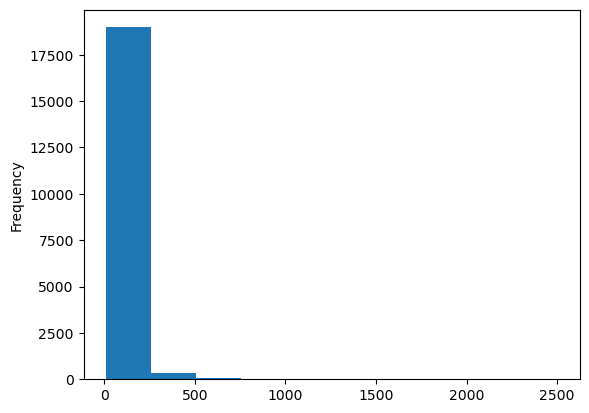

In [30]:
wine["price"].plot(kind='hist')

#### As seen on the graph we have a lot of "cheap" wine bottles (less than 250 $) and only a few of prestige. Let's create 8 price segments.

In [31]:
pd.qcut(wine["price"], q=8)

0        (100.0, 2500.0]
1        (100.0, 2500.0]
2        (100.0, 2500.0]
3          (75.0, 100.0]
4        (100.0, 2500.0]
              ...       
19372       (62.0, 75.0]
19373       (30.0, 38.0]
19374       (45.0, 52.0]
19375       (45.0, 52.0]
19376     (10.999, 30.0]
Name: price, Length: 19377, dtype: category
Categories (8, interval[float64, right]): [(10.999, 30.0] < (30.0, 38.0] < (38.0, 45.0] < (45.0, 52.0] < (52.0, 62.0] < (62.0, 75.0] < (75.0, 100.0] < (100.0, 2500.0]]

#### Above code suggests us a range of prices for each segment. It would work if we want to have the same number of observations in every segment but we don't so let's modify it a little but based on it.

##### Therefore we will be using these price ranges to define the segments:
#####    - Low-Price [0 - 30.0]
#####    - Reasonable (30.0 - 55.0]
#####    - Standard (55.0 - 80.0]
#####    - High-Price (80.0 - 120.0]
#####    - Premium (120.0 - 250.0]
#####    - Super Premium (250.0 - 500.0]
#####    - Prestige (500.0 - 1000.00]
#####    - Super Prestige (1000.0 - 2500.0]

#### We will work on a copy of the price column

In [32]:
wine["price segment"] = wine["price"]

### Loop to sort each wine to its right price segment

In [33]:
segment = []

for row in wine["price segment"]:
    if row < 30:
        segment.append('LowPrice')
    elif row < 55:
        segment.append('Reasonable')
    elif row < 80:
        segment.append('Standard')
    elif row < 120:
        segment.append('High-Price')
    elif row < 250:
        segment.append('Premium')
    elif row < 500:
        segment.append('SuperPremium')
    elif row < 1000:
        segment.append('Prestige')
    elif row >= 1000:
        segment.append('SuperPrestige')
    else:
        segment.append('Error')
        
wine['price segment'] = segment

#### Here we can see how many wines we have for each of the segments we set

In [34]:
wine['price segment'].value_counts()

price segment
Reasonable       7595
Standard         4904
High-Price       2590
LowPrice         2341
Premium          1498
SuperPremium      352
Prestige           83
SuperPrestige      14
Name: count, dtype: int64

#### We have to rebuild our metadata and we will limit it to the most important variables to have more varied recommendations.

In [35]:
def metadata(x):
    return ''.join(x['points']) + ' ' + x['price segment'] + ' ' + x['variety']

In [36]:
wine['metadata'] = wine.apply(metadata, axis=1)

#### Once again we have to create the new similarity matrix as done in previous steps

In [37]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(wine['metadata']) 

In [38]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [39]:
wine = wine.reset_index()
indices = pd.Series(wine.index, index=wine['title'])

In [40]:
wine = wine[['title', 'country', 'description', 'points', 'price', 'price segment', 'province', 'variety', 'winery']]

In [41]:
def wine_recommendations(title, cosine_sim=cosine_sim):
    
    # Fit index of the wine to the title
    idx = indices[title]
    
    # Calculate the similarity score between wine which you selected and the others wines in database
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the results by the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Show the top 10 results with the highest similarity score
    sim_scores = sim_scores[1:10]

    # Extract indices of the recommended wines
    wine_indices = [i[0] for i in sim_scores]

    # Create new dataframe
    recommendation = wine[['title', 'country', 'description', 'points', 'price', 'price segment', 'province', 'variety', 'winery']].iloc[wine_indices]

    # Combine selected wine and recommendations in this new dataframe
    frames = [wine[wine["title"] == title], recommendation]
    recommendation = pd.concat(frames, keys=['x', 'y'])
    
    # Return the result recommendation
    return recommendation

In [42]:
Recommendation = wine_recommendations('Château Mouton Rothschild 2009  Pauillac')
Recommendation

title country  \
x 771           Château Mouton Rothschild 2009  Pauillac  France   
y 759            Château Haut-Brion 2009  Pessac-Léognan  France   
  771           Château Mouton Rothschild 2009  Pauillac  France   
  9             Château Lafite Rothschild 2010  Pauillac  France   
  16            Château Cheval Blanc 2010  Saint-Émilion  France   
  83                       Château Margaux 2009  Margaux  France   
  122  Château La Mission Haut-Brion 2009  Pessac-Léo...  France   
  293                       Château Pétrus 2011  Pomerol  France   
  326   Portfolio 2013 Limited Edition Red (Napa Valley)      US   
  330           Château Mouton Rothschild 2014  Pauillac  France   

                                             description points   price  \
x 771  The purest Cabernet Sauvignon fruit, with dark...     96  1300.0   
y 759  Solid, very structured, packed with dense and ...     96  1200.0   
  771  The purest Cabernet Sauvignon fruit, with dark...     96  1300.0   
  9    Almost black in color, this stunning wine is g...    100  1500.0   
  16   This is the finest Cheval Blanc for many years...    100  1500.0   
  83   A massive wine for Margaux, packed with tannin...     98  1900.0   
  122  Such a generous and ripe wine, with a dark cor...     97  1100.0   
  293  This extravagantly perfumed wine has great jui...     97  2000.0   
  326  Robert Mondavi winemaker Genevieve Janssens ma...     96   155.0   
  330  The label of this vintage is designed by David...     96   400.0   

       price segment    province                   variety  \
x 771  SuperPrestige    Bordeaux  Bordeaux-style Red Blend   
y 759  SuperPrestige    Bordeaux  Bordeaux-style Red Blend   
  771  SuperPrestige    Bordeaux  Bordeaux-style Red Blend   
  9    SuperPrestige    Bordeaux  Bordeaux-style Red Blend   
  16   SuperPrestige    Bordeaux  Bordeaux-style Red Blend   
  83   SuperPrestige    Bordeaux  Bordeaux-style Red Blend   
  122  SuperPrestige    Bordeaux  Bordeaux-style Red Blend   
  293  SuperPrestige    Bordeaux  Bordeaux-style Red Blend   
  326        Premium  California  Bordeaux-style Red Blend   
  330   SuperPremium    Bordeaux  Bordeaux-style Red Blend   

                              winery  
x 771      Château Mouton Rothschild  
y 759             Château Haut-Brion  
  771      Château Mouton Rothschild  
  9        Château Lafite Rothschild  
  16            Château Cheval Blanc  
  83                 Château Margaux  
  122  Château La Mission Haut-Brion  
  293                 Château Pétrus  
  326                      Portfolio  
  330      Château Mouton Rothschild

#### Now these recommendations which we created are better. As you see, "Château Mouton Rothschild 2009 Pauillac" has a lot of positive reviews (96 points) but it is a really expensive wine (1300 USD per bottle) and not so many people could afford to buy it. Thanks to the latest version of the engine, we found alternatives which are "Portfolio 2013 Limited Edition Red (Napa Valley)" for 155 USD per bottle and "Château Mouton Rothschild 2014 Pauillac" for 400 USD per bottle. So before you buy the "Château Mouton Rothschild 2009 Pauillac" for 1300 USD, take a look on the same wine from 2010 which has the best reviews (100 points!) and the price is "only" 200 USD higher.